In [1]:
# Import libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths to dataset directories (Kaggle dataset structure)
base_path = '/kaggle/input/voronoi-artificial-grains-gen/GRAIN DATA SET/'
ag_path = os.path.join(base_path, 'AG')
ag_mask_path = os.path.join(base_path, 'AGMask')
rg_path = os.path.join(base_path, 'RG')
rg_mask_path = os.path.join(base_path, 'RGMask')
hed_pre_path = os.path.join(base_path, 'HED_PRE')
grad_pre_path = os.path.join(base_path, 'GRAD_PRE')
thresh_pre_path = os.path.join(base_path, 'THRESH_PRE')

# List files to ensure data is accessible
print(f"AG files: {len(os.listdir(ag_path))}")
print(f"AGMask files: {len(os.listdir(ag_mask_path))}")
print(f"RG files: {len(os.listdir(rg_path))}")
print(f"RGMask files: {len(os.listdir(rg_mask_path))}")

Using device: cuda
AG files: 800
AGMask files: 800
RG files: 480
RGMask files: 480


In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
class GrainDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('L')  # Grayscale
        mask = Image.open(self.mask_paths[idx]).convert('L')    # Grayscale

        # Convert to numpy arrays and normalize
        image = np.array(image, dtype=np.float32) / 255.0  # [0, 1]
        mask = np.array(mask, dtype=np.float32) / 255.0    # [0, 1]

        # Strict binarization for mask (0 or 1)
        mask = np.where(mask > 0.5, 1.0, 0.0)

        # Convert to PyTorch tensors
        image = torch.from_numpy(image).unsqueeze(0)  # [1, H, W]
        mask = torch.from_numpy(mask).unsqueeze(0)    # [1, H, W]

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transform (input size divisible by 16 for 4 pooling layers)
transform = transforms.Compose([
    transforms.Resize((304, 400)),  # 304 ÷ 16 = 19, 400 ÷ 16 = 25
])

# Load file paths
ag_images = sorted([os.path.join(ag_path, f) for f in os.listdir(ag_path)])
ag_masks = sorted([os.path.join(ag_mask_path, f) for f in os.listdir(ag_mask_path)])
rg_images = sorted([os.path.join(rg_path, f) for f in os.listdir(rg_path)])
rg_masks = sorted([os.path.join(rg_mask_path, f) for f in os.listdir(rg_mask_path)])

# Split into train and test (example: Training Set 3 - 50% RG + 50% AG)
ag_train_img, ag_test_img, ag_train_mask, ag_test_mask = train_test_split(
    ag_images, ag_masks, test_size=0.2, random_state=42
)
rg_train_img, rg_test_img, rg_train_mask, rg_test_mask = train_test_split(
    rg_images, rg_masks, test_size=0.2, random_state=42
)

train_images = rg_train_img[:len(rg_train_img)//2] + ag_train_img[:len(ag_train_img)//2]
train_masks = rg_train_mask[:len(rg_train_mask)//2] + ag_train_mask[:len(ag_train_mask)//2]
test_images = rg_test_img + ag_test_img
test_masks = rg_test_mask + ag_test_mask

# Create datasets and loaders
train_dataset = GrainDataset(train_images, train_masks, transform=transform)
test_dataset = GrainDataset(test_images, test_masks, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Verify a sample
image, mask = train_dataset[0]
print(f"Sample image shape: {image.shape}, min: {image.min()}, max: {image.max()}")
print(f"Sample mask shape: {mask.shape}, min: {mask.min()}, max: {mask.max()}")

Sample image shape: torch.Size([1, 304, 400]), min: 0.0015180421760305762, max: 0.9960784316062927
Sample mask shape: torch.Size([1, 304, 400]), min: 0.0, max: 1.0000000000000002


In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)

        # Encoder
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder
        self.up4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64)

        # Output (logits)
        self.out_conv = nn.Conv2d(64, 1, 1)

    def crop_or_pad(self, source, target):
        """Align source tensor spatial dims to target tensor."""
        _, _, h_s, w_s = source.size()
        _, _, h_t, w_t = target.size()

        if h_s > h_t:
            source = source[:, :, :h_t, :]
        elif h_s < h_t:
            pad_h = h_t - h_s
            source = nn.functional.pad(source, (0, 0, 0, pad_h))

        if w_s > w_t:
            source = source[:, :, :, :w_t]
        elif w_s < w_t:
            pad_w = w_t - w_s
            source = nn.functional.pad(source, (0, pad_w))

        return source

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.up4(b)
        e4 = self.crop_or_pad(e4, d4)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        e3 = self.crop_or_pad(e3, d3)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        e2 = self.crop_or_pad(e2, d2)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e1 = self.crop_or_pad(e1, d1)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        # Output logits
        out = self.out_conv(d1)
        return out

# Initialize model
model = UNet().to(device)

In [6]:
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        logits = model(images)
        loss = criterion(logits, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Debug every few batches
        if i % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# Save the model
torch.save(model.state_dict(), 'unet_grain_segmentation.pth')

In [11]:
## evaluate
def dice_score(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    pred = (pred > 0.5).float()  # Binarize
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Evaluate
model.eval()
dice_scores = []
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        logits = model(images)
        dice = dice_score(logits, masks)
        dice_scores.append(dice.item())

avg_dice = np.mean(dice_scores)
print(f"Average Dice Score: {avg_dice:.4f}")

Average Dice Score: 0.9405


In [12]:


"""
# Step 6: Evaluate with Dice Score and Grain Measurements
import cv2  # For edge detection in grain size calculation

def dice_score(pred, target, smooth=1e-5):
    """Compute Dice score between prediction and target."""
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    pred = (pred > 0.5).float()  # Binarize
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def line_intercept_grain_size(mask, pixel_size=1.0):
    """Estimate grain size using the line intercept method.
    Args:
        mask: Binary mask (0 for boundaries, 1 for grains) as numpy array [H, W]
        pixel_size: Physical size per pixel (default 1.0 for pixel units)
    Returns:
        Grain size in units of pixel_size (e.g., pixels or micrometers if calibrated)
    """
    # Ensure mask is binary (0 or 1) and in uint8 format for OpenCV
    mask = (mask > 0.5).astype(np.uint8) * 255  # 0 (boundaries), 255 (grains)
    
    # Extract a horizontal line from the middle of the image
    height, width = mask.shape
    line = mask[height // 2, :]  # Middle row
    
    # Detect edges (grain boundaries) using Canny
    edges = cv2.Canny(line.reshape(1, -1), 100, 200)
    
    # Count intercepts (transitions from grain to boundary)
    num_intercepts = np.sum(edges > 0) // 2  # Divide by 2 as each boundary has 2 edges
    
    # Calculate average grain size (line length / number of intercepts)
    grain_size = (width * pixel_size) / num_intercepts if num_intercepts > 0 else width * pixel_size
    return grain_size

# Evaluate model
model.eval()
dice_scores = []
grain_sizes_pred = []
grain_sizes_true = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        logits = model(images)
        
        # Compute Dice score
        dice = dice_score(logits, masks)
        dice_scores.append(dice.item())
        
        # Convert tensors to numpy for grain size calculation
        pred_probs = torch.sigmoid(logits).cpu().numpy()  # [B, 1, H, W]
        pred_masks = (pred_probs > 0.5).astype(np.float32)  # Binarize
        true_masks = masks.cpu().numpy()  # [B, 1, H, W]
        
        # Calculate grain size for each image in the batch
        for i in range(pred_masks.shape[0]):
            pred_mask = pred_masks[i, 0]  # [H, W]
            true_mask = true_masks[i, 0]  # [H, W]
            
            pred_size = line_intercept_grain_size(pred_mask)
            true_size = line_intercept_grain_size(true_mask)
            
            grain_sizes_pred.append(pred_size)
            grain_sizes_true.append(true_size)

# Compute averages
avg_dice = np.mean(dice_scores)
avg_grain_size_pred = np.mean(grain_sizes_pred)
avg_grain_size_true = np.mean(grain_sizes_true)

# Report results
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average Predicted Grain Size (pixels): {avg_grain_size_pred:.2f}")
print(f"Average True Grain Size (pixels): {avg_grain_size_true:.2f}")
print(f"Grain Size Difference (Pred - True): {avg_grain_size_pred - avg_grain_size_true:.2f}")

"""

SyntaxError: invalid syntax (<ipython-input-12-d0a88b93c9de>, line 6)

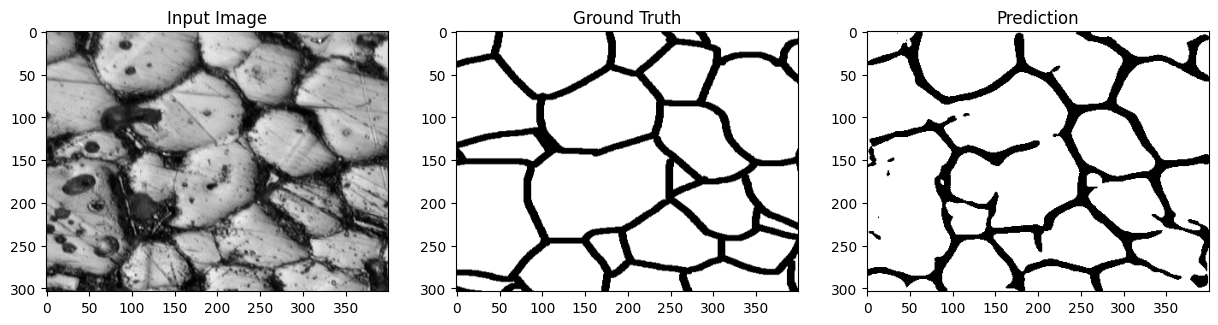

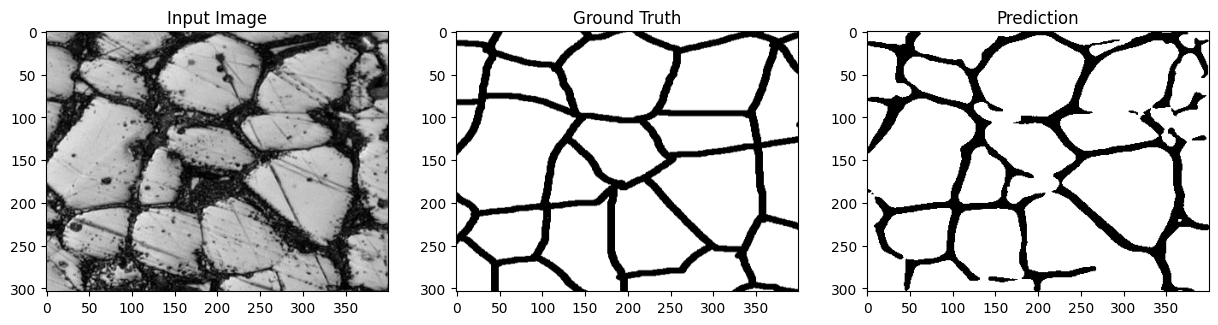

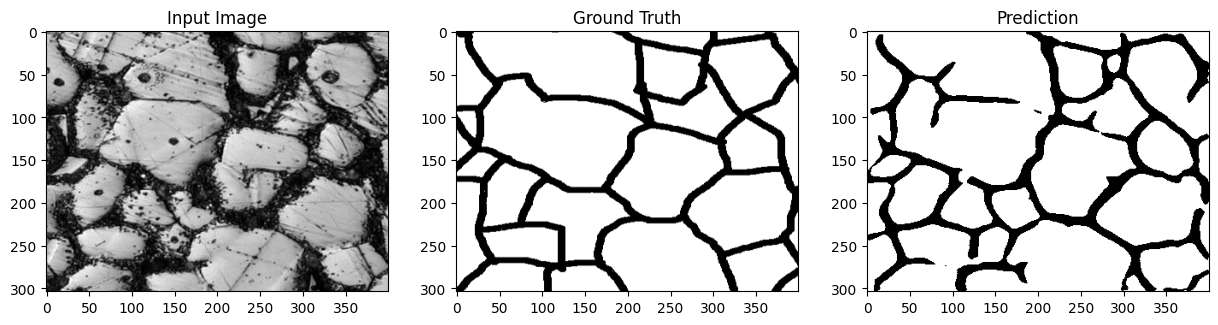

In [13]:
def visualize_prediction(image, mask, pred):
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    pred = (pred > 0.5).float()  # Binarize
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.squeeze(), cmap='gray')
    ax[0].set_title('Input Image')
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth')
    ax[2].imshow(pred.squeeze(), cmap='gray')
    ax[2].set_title('Prediction')
    plt.show()

# Visualize a few examples
model.eval()
with torch.no_grad():
    for i in range(3):
        image, mask = test_dataset[i]
        image_tensor = image.unsqueeze(0).to(device)
        pred = model(image_tensor).cpu()
        visualize_prediction(image.numpy(), mask.numpy(), pred)